In [1]:
%matplotlib widget
%matplotlib inline

import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
# from stingray import stats


sns.set_context('paper', font_scale=2.0)
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *



# Setup

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/GRS_1741d9m2853/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/GRS_1741d9m2853/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90601317002'
    

Working on Macbook


Text(0, 0.5, 'NuSTAR count rate')

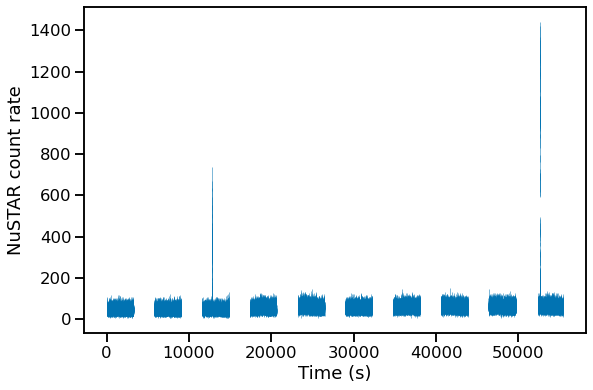

In [9]:
plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
# plt.close()


In [10]:
HR_binsize = 128
buff = 0
curveA_128 = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_3to78keV/nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_3to78keV/nu' + OBSID + 'A01_bk.lc'))
curveB_128 = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_3to78keV/nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_3to78keV/nu' + OBSID + 'B01_bk.lc'))
curve_total_128 = sum_lc(curveA_128, curveB_128).rebin(dt_new=128)

soft_curves = [sum_lc(bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/nu' + OBSID + 'A01_bk.lc')), 
                      bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/nu' + OBSID + 'B01_bk.lc'))).rebin(dt_new = HR_binsize),    
               sum_lc(bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/nu' + OBSID + 'A01_bk.lc')), 
                      bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/nu' + OBSID + 'B01_bk.lc'))).rebin(dt_new = HR_binsize)]

hard_curves = [sum_lc(bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/nu' + OBSID + 'A01_bk.lc')),
                   bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/nu' + OBSID + 'B01_bk.lc'))).rebin(dt_new = HR_binsize),    
               sum_lc(bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_25to50keV/nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_25to50keV/nu' + OBSID + 'A01_bk.lc')), 
                   bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_25to50keV/nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_25to50keV/nu' + OBSID + 'B01_bk.lc'))).rebin(dt_new = HR_binsize)]


common_time = curve_total_128.time
soft_color = (soft_curves[1].counts)/(soft_curves[0].counts)
soft_err = soft_color*np.sqrt((1.0/soft_curves[1].counts) + (1.0/soft_curves[0].counts))

hard_color = (hard_curves[1].counts)/(hard_curves[0].counts)
hard_err = hard_color*np.sqrt((1.0/hard_curves[1].counts) + (1.0/hard_curves[0].counts))



/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


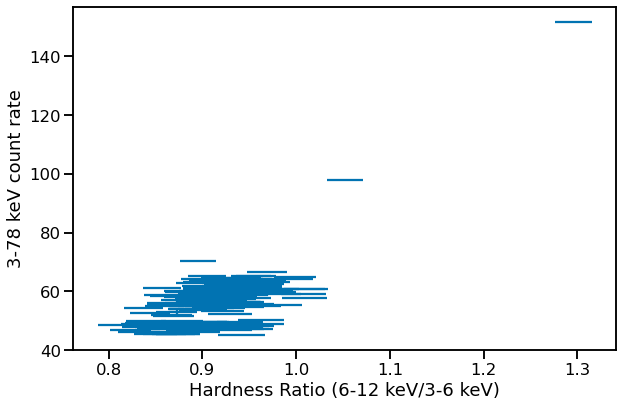

In [11]:
plt.figure(figsize=(9,6))
plt.errorbar(soft_color, curve_total_128.countrate, xerr = soft_err, yerr=curve_total_128.countrate_err, fmt='none')
plt.xlabel('Hardness Ratio (6-12 keV/3-6 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()


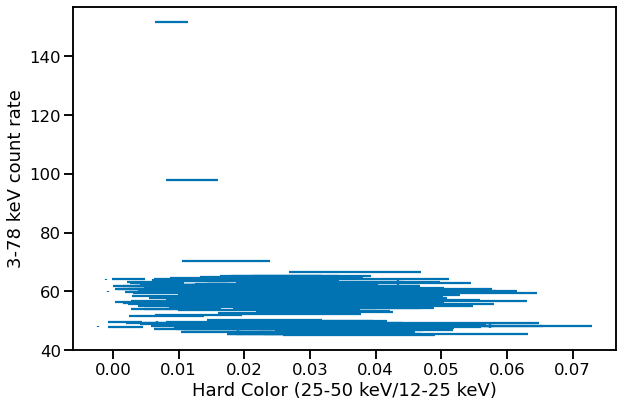

In [12]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, curve_total_128.countrate, xerr = hard_err, yerr=curve_total_128.countrate_err, fmt='none')
plt.xlabel('Hard Color (25-50 keV/12-25 keV)')
plt.ylabel('3-78 keV count rate')
plt.tight_layout()

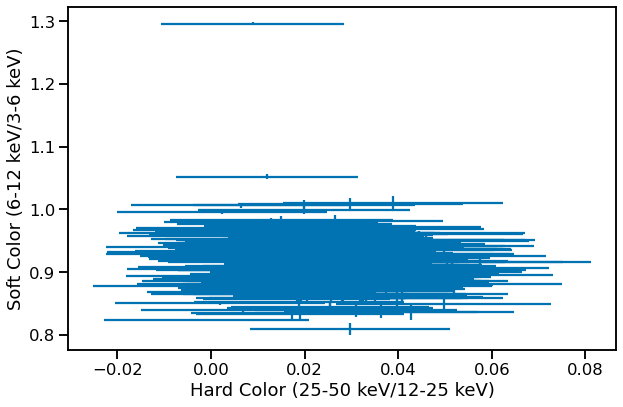

In [13]:
plt.figure(figsize=(9,6))
plt.errorbar(hard_color, soft_color, xerr = soft_err, yerr=hard_err, fmt='none')
plt.xlabel('Hard Color (25-50 keV/12-25 keV)')
plt.ylabel('Soft Color (6-12 keV/3-6 keV)')
plt.tight_layout()


In [3]:
lw = 1.5
ls=''

file_comp_gauss_ldata = open(root_dir + 'persistent_products/tbabs_bbrad_nthcomp_gauss_ldata.qdp', 'r')
file_comp_gauss_eeufspec = open(root_dir + 'persistent_products/tbabs_bbrad_nthcomp_gauss_eeufspec.qdp', 'r')

data_comp_gauss_ldata = read_QDP(file_comp_gauss_ldata)
data_comp_gauss_eeufspec = read_QDP(file_comp_gauss_eeufspec)


file_pl_refl_ldata = open(root_dir + 'persistent_products/tbnew_gas_cutoffpl_bbrad_relxillNS_ldata.qdp', 'r')
file_pl_refl_eeufspec = open(root_dir + 'persistent_products/tbnew_gas_cutoffpl_bbrad_relxillNS_eeufspec.qdp', 'r')

data_pl_refl_ldata = read_QDP(file_pl_refl_ldata)
data_pl_refl_eeufspec = read_QDP(file_pl_refl_eeufspec)


file_pl_ldata = open(root_dir + 'persistent_products/tbnew_gas_powerlaw_ldata.qdp', 'r')
file_pl_eeufspec = open(root_dir + 'persistent_products/tbnew_gas_powerlaw_ldata.qdp', 'r')

data_pl_ldata = read_QDP(file_pl_ldata)
data_pl_eeufspec = read_QDP(file_pl_eeufspec)




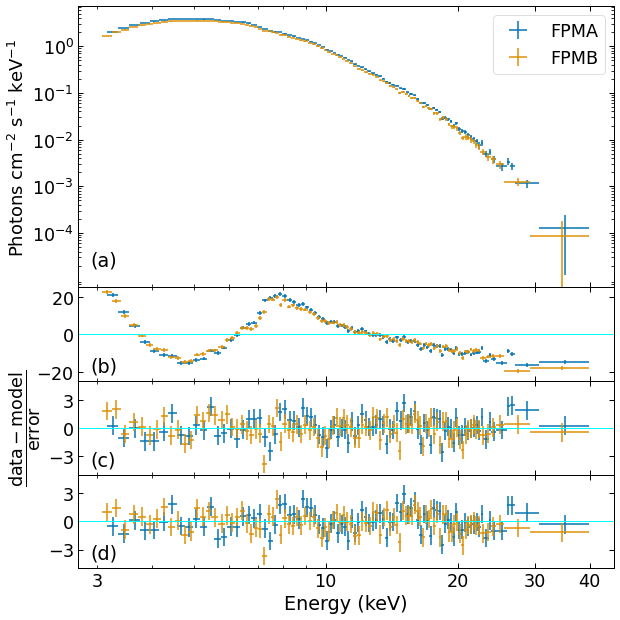

In [65]:
sns.set_palette('colorblind')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True,  gridspec_kw = {'height_ratios':[3, 1,1,1], 'hspace':0}, figsize=(9, 9))
ax1.errorbar(data_pl_ldata[0][0],data_pl_ldata[0][2], xerr=data_pl_ldata[0][1], yerr=data_pl_ldata[0][3], \
             ls=ls, lw=lw, color='C0', label = 'FPMA')
ax1.errorbar(data_pl_ldata[1][0],data_pl_ldata[1][2], xerr=data_pl_ldata[1][1], yerr=data_pl_ldata[1][3], \
             ls=ls, lw=lw, color='C1', label = 'FPMB')

ax2.errorbar(data_pl_eeufspec[0][0],(data_pl_eeufspec[0][2]-data_pl_eeufspec[0][4])/data_pl_eeufspec[0][3], xerr=data_pl_eeufspec[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax2.errorbar(data_pl_eeufspec[1][0],(data_pl_eeufspec[1][2] - data_pl_eeufspec[1][4])/data_pl_eeufspec[1][3], xerr=data_pl_eeufspec[1][1],yerr=1.0, \
             ls=ls, color='C1', lw=lw)

ax3.errorbar(data_comp_gauss_eeufspec[0][0],(data_comp_gauss_eeufspec[0][2]-data_comp_gauss_eeufspec[0][4])/data_comp_gauss_eeufspec[0][3], xerr=data_comp_gauss_eeufspec[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax3.errorbar(data_comp_gauss_eeufspec[1][0],(data_comp_gauss_eeufspec[1][2] - data_comp_gauss_eeufspec[1][4])/data_comp_gauss_eeufspec[1][3], xerr=data_comp_gauss_eeufspec[1][1],yerr=1.0, \
             ls=ls, color='C1', lw=lw)

ax4.errorbar(data_pl_refl_eeufspec[0][0],(data_pl_refl_eeufspec[0][2]-data_pl_refl_eeufspec[0][4])/data_pl_refl_eeufspec[0][3], xerr=data_pl_refl_eeufspec[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax4.errorbar(data_pl_refl_eeufspec[1][0],(data_pl_refl_eeufspec[1][2] - data_pl_refl_eeufspec[1][4])/data_pl_refl_eeufspec[1][3], xerr=data_pl_refl_eeufspec[1][1],yerr=1.0, \
             ls=ls, color='C1', lw=lw)

ax1.legend()
ax1.loglog()
plt.xlabel('Energy (keV)')
ax1.set_ylabel(r'$\mathrm{Photons\ cm^{-2}\ s^{-1}\ keV^{-1}}$', fontsize=18)
# ax2.set_ylabel(r'$\frac{data}{model}$')
# ax2.axhline(1,color='cyan', lw=1.0)
ax3.set_ylabel(r'$\mathrm{\frac{data-model}{error}}$', fontsize=25)
ax2.axhline(0,color='cyan', lw=1.0)
ax3.axhline(0,color='cyan', lw=1.0)
ax4.axhline(0,color='cyan', lw=1.0)

ax2.set_ylim(-25,25)
ax3.set_ylim(-5,5)
ax4.set_ylim(-5,5)

ax1.text(2.9, 2e-5, '(a)')
ax2.text(2.9, -20, '(b)')
ax3.text(2.9, -4, '(c)')
ax4.text(2.9, -4, '(d)')

ax1.set_yticks(ticks= [1e-4, 1e-3, 1e-2, 1e-1, 1e0], minor=False)
# ax1.set_yticks(ticks= [], minor=True)

ax2.set_yticks(ticks= [-20, 0, 20], minor=False)
ax2.set_yticklabels(labels= [r'$-20$', r'$0$', r'$20$'], minor=False)

ax3.set_yticks(ticks= [-3, 0, 3], minor=False)
ax3.set_yticklabels(labels= [r'$-3$', r'$0$', r'$3$'], minor=False)

ax4.set_yticks(ticks= [-3, 0, 3], minor=False)
ax4.set_yticklabels(labels= [r'$-3$', r'$0$', r'$3$'], minor=False)

ax4.set_xticks(ticks= [10,20,30,40], minor=False)
ax4.set_xticklabels(labels= [10,20,30,40], minor=False)

ax4.set_xticks(ticks= [3, 4, 5, 6, 7, 8, 9], minor=True)
ax4.set_xticklabels(labels= [3, '', '', '', '', '', ''], minor=True)

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax4.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)


plt.tight_layout()
plt.savefig(plot_dir + 'spectra.pdf')



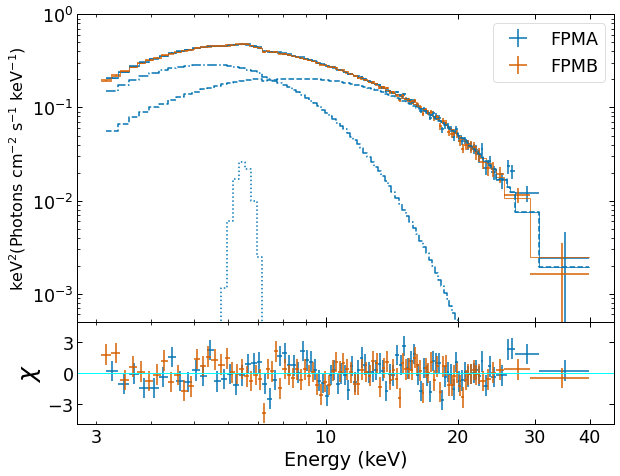

In [4]:
sns.set_palette('colorblind')

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,  gridspec_kw = {'height_ratios':[3, 1], 'hspace':0}, figsize=(9, 7))
ax1.errorbar(data_comp_gauss_eeufspec[0][0],data_comp_gauss_eeufspec[0][2], xerr=data_comp_gauss_eeufspec[0][1], yerr=data_comp_gauss_eeufspec[0][3], \
             ls=ls, lw=lw, color='C0', label = 'FPMA')
ax1.errorbar(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][2], xerr=data_comp_gauss_eeufspec[1][1], yerr=data_comp_gauss_eeufspec[1][3], \
             ls=ls, lw=lw, color='C3', label = 'FPMB')

ax1.step(np.concatenate([data_comp_gauss_eeufspec[0][0]-data_comp_gauss_eeufspec[0][1], [data_comp_gauss_eeufspec[0][0][-1]+data_comp_gauss_eeufspec[0][1][-1]]]), \
         np.concatenate([data_comp_gauss_eeufspec[0][4], [data_comp_gauss_eeufspec[0][4][-1]]]), where='post', color='C0', lw=0.5*lw)
ax1.step(np.concatenate([data_comp_gauss_eeufspec[1][0]-data_comp_gauss_eeufspec[1][1], [data_comp_gauss_eeufspec[1][0][-1]+data_comp_gauss_eeufspec[1][1][-1]]]), \
         np.concatenate([data_comp_gauss_eeufspec[1][4], [data_comp_gauss_eeufspec[1][4][-1]]]), where='post', color='C3', lw=0.5*lw)

ax1.step(np.concatenate([data_comp_gauss_eeufspec[0][0]-data_comp_gauss_eeufspec[0][1], [data_comp_gauss_eeufspec[0][0][-1]+data_comp_gauss_eeufspec[0][1][-1]]]), \
         np.concatenate([data_comp_gauss_eeufspec[0][5], [data_comp_gauss_eeufspec[0][5][-1]]]), where='post', color='C0', ls='dashed', lw=lw)
# ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][5], where='mid', color='C1', ls='dashed', lw=lw)

ax1.step(np.concatenate([data_comp_gauss_eeufspec[0][0]-data_comp_gauss_eeufspec[0][1], [data_comp_gauss_eeufspec[0][0][-1]+data_comp_gauss_eeufspec[0][1][-1]]]), \
         np.concatenate([data_comp_gauss_eeufspec[0][6], [data_comp_gauss_eeufspec[0][6][-1]]]), where='post', color='C0', ls='dotted', lw=lw)
# ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][6], where='mid', color='C1', ls='dotted', lw=lw)

ax1.step(np.concatenate([data_comp_gauss_eeufspec[0][0]-data_comp_gauss_eeufspec[0][1], [data_comp_gauss_eeufspec[0][0][-1]+data_comp_gauss_eeufspec[0][1][-1]]]), \
         np.concatenate([data_comp_gauss_eeufspec[0][7], [data_comp_gauss_eeufspec[0][7][-1]]]), where='post', color='C0', ls='dashdot', lw=lw)
# ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][7], where='mid', color='C1', ls='dotted', lw=lw)

ax2.errorbar(data_comp_gauss_eeufspec[0][0],(data_comp_gauss_eeufspec[0][2]-data_comp_gauss_eeufspec[0][4])/data_comp_gauss_eeufspec[0][3], xerr=data_comp_gauss_eeufspec[0][1], yerr=1.0, \
             ls=ls, color='C0', lw=lw)
ax2.errorbar(data_comp_gauss_eeufspec[1][0],(data_comp_gauss_eeufspec[1][2] - data_comp_gauss_eeufspec[1][4])/data_comp_gauss_eeufspec[1][3], xerr=data_comp_gauss_eeufspec[1][1],yerr=1.0, \
             ls=ls, color='C3', lw=lw)
ax1.set_ylim(5e-4,1)
ax1.legend()
ax1.loglog()
plt.xlabel('Energy (keV)')
ax1.set_ylabel(r'$\mathrm{keV^{2}(Photons\ cm^{-2}\ s^{-1}\ keV^{-1})}$', fontsize=16)
# ax2.set_ylabel(r'$\frac{data}{model}$')
# ax2.axhline(1,color='cyan', lw=1.0)
ax2.set_ylabel(r'$\chi$', fontsize=25)
ax2.axhline(0,color='cyan', lw=1.0)
ax2.set_ylim(-5,5)

# ax1.text(2.9, 2e-5, '(a)')
# ax2.text(2.9, -4, '(b)')

ax1.set_yticks(ticks= [1e-3, 1e-2, 1e-1, 1e0], minor=False)
# ax1.set_yticks(ticks= [], minor=True)

ax2.set_yticks(ticks= [-3, 0, 3], minor=False)
ax2.set_yticklabels(labels= [r'$-3$', r'$0$', r'$3$'], minor=False)

ax2.set_xticks(ticks= [10,20,30,40], minor=False)
ax2.set_xticklabels(labels= [10,20,30,40], minor=False)

ax2.set_xticks(ticks= [3, 4, 5, 6, 7, 8, 9], minor=True)
ax2.set_xticklabels(labels= [3, '', '', '', '', '', ''], minor=True)

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)

plt.tight_layout()
plt.savefig(plot_dir + 'spectra_model.pdf')



In [5]:
lw = 1.5
ls=''

file_burst1 = open(root_dir + 'burst1/products/persistent_bb_eeufspec_noconst.qdp', 'r')

data_burst1 = read_QDP(file_burst1)

file_burst2 = open(root_dir + 'burst2/products/persistent_bb_eeufspec_noconst.qdp', 'r')

data_burst2 = read_QDP(file_burst2)


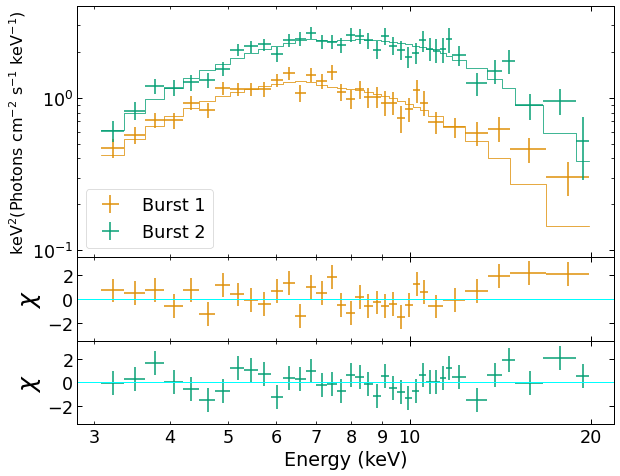

In [6]:
sns.set_palette('colorblind')

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True,  gridspec_kw = {'height_ratios':[3, 1, 1], 'hspace':0}, figsize=(9, 7))

ax1.errorbar(data_burst1[0][0],data_burst1[0][2], xerr=data_burst1[0][1], yerr=data_burst1[0][3], \
             ls=ls, lw=lw, color='C1', label = 'Burst 1')
# ax1.errorbar(data_burst1[1][0],data_burst1[1][2], xerr=data_burst1[1][1], yerr=data_burst1[1][3], \
#              ls=ls, lw=lw, color='C1')

ax1.errorbar(data_burst2[0][0],data_burst2[0][2], xerr=data_burst2[0][1], yerr=data_burst2[0][3], \
             ls=ls, lw=lw, color='C2', label = 'Burst 2')
# ax1.errorbar(data_burst2[1][0],data_burst2[1][2], xerr=data_burst2[1][1], yerr=data_burst2[1][3], \
#              ls=ls, lw=lw, color='C2')

ax1.step(np.concatenate([data_burst1[0][0]-data_burst1[0][1], [data_burst1[0][0][-1]+data_burst1[0][1][-1]]]), \
         np.concatenate([data_burst1[0][4], [data_burst1[0][4][-1]]]), where='post', color='C1', lw=0.5*lw)
# ax1.step(np.concatenate([data_burst1[1][0]-data_burst1[1][1], [data_burst1[1][0][-1]+data_burst1[1][1][-1]]]), \
#          np.concatenate([data_burst1[1][4], [data_burst1[1][4][-1]]]), where='post', color='C1', lw=0.5*lw)

# ax1.step(np.concatenate([data_burst1[0][0]-data_burst1[0][1], [data_burst1[0][0][-1]+data_burst1[0][1][-1]]]), \
#          np.concatenate([data_burst1[0][5], [data_burst1[0][5][-1]]]), where='post', color='C0', ls='dashed', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][5], where='mid', color='C1', ls='dashed', lw=lw)

# ax1.step(np.concatenate([data_burst1[0][0]-data_burst1[0][1], [data_burst1[0][0][-1]+data_burst1[0][1][-1]]]), \
#          np.concatenate([data_burst1[0][6], [data_burst1[0][6][-1]]]), where='post', color='C0', ls='dotted', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][6], where='mid', color='C1', ls='dotted', lw=lw)

# ax1.step(np.concatenate([data_burst1[0][0]-data_burst1[0][1], [data_burst1[0][0][-1]+data_burst1[0][1][-1]]]), \
#          np.concatenate([data_burst1[0][7], [data_burst1[0][7][-1]]]), where='post', color='C0', ls='dashdot', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][7], where='mid', color='C1', ls='dotted', lw=lw)

# ax1.step(np.concatenate([data_burst1[0][0]-data_burst1[0][1], [data_burst1[0][0][-1]+data_burst1[0][1][-1]]]), \
#          np.concatenate([data_burst1[0][8], [data_burst1[0][8][-1]]]), where='post', color='C0', ls='doubledot', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][7], where='mid', color='C1', ls='dotted', lw=lw)



ax2.errorbar(data_burst1[0][0],(data_burst1[0][2]-data_burst1[0][4])/data_burst1[0][3], xerr=data_burst1[0][1], yerr=1.0, \
             ls=ls, color='C1', lw=lw)
# ax2.errorbar(data_burst1[1][0],(data_burst1[1][2] - data_burst1[1][4])/data_burst1[1][3], xerr=data_burst1[1][1],yerr=1.0, \
#              ls=ls, color='C1', lw=lw)



ax1.step(np.concatenate([data_burst2[0][0]-data_burst2[0][1], [data_burst2[0][0][-1]+data_burst2[0][1][-1]]]), \
         np.concatenate([data_burst2[0][4], [data_burst2[0][4][-1]]]), where='post', color='C2', lw=0.5*lw)
# ax1.step(np.concatenate([data_burst2[1][0]-data_burst2[1][1], [data_burst2[1][0][-1]+data_burst2[1][1][-1]]]), \
#          np.concatenate([data_burst2[1][4], [data_burst2[1][4][-1]]]), where='post', color='C2', lw=0.5*lw)

# ax1.step(np.concatenate([data_burst2[0][0]-data_burst2[0][1], [data_burst2[0][0][-1]+data_burst2[0][1][-1]]]), \
#          np.concatenate([data_burst2[0][5], [data_burst2[0][5][-1]]]), where='post', color='C0', ls='dashed', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][5], where='mid', color='C1', ls='dashed', lw=lw)

# ax1.step(np.concatenate([data_burst2[0][0]-data_burst2[0][1], [data_burst2[0][0][-1]+data_burst2[0][1][-1]]]), \
#          np.concatenate([data_burst2[0][6], [data_burst2[0][6][-1]]]), where='post', color='C0', ls='dotted', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][6], where='mid', color='C1', ls='dotted', lw=lw)

# ax1.step(np.concatenate([data_burst2[0][0]-data_burst2[0][1], [data_burst2[0][0][-1]+data_burst2[0][1][-1]]]), \
#          np.concatenate([data_burst2[0][7], [data_burst2[0][7][-1]]]), where='post', color='C0', ls='dashdot', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][7], where='mid', color='C1', ls='dotted', lw=lw)

# ax1.step(np.concatenate([data_burst2[0][0]-data_burst2[0][1], [data_burst2[0][0][-1]+data_burst2[0][1][-1]]]), \
#          np.concatenate([data_burst2[0][8], [data_burst2[0][8][-1]]]), where='post', color='C0', ls='doubledot', lw=lw)
# # ax1.step(data_comp_gauss_eeufspec[1][0],data_comp_gauss_eeufspec[1][7], where='mid', color='C1', ls='dotted', lw=lw)



ax3.errorbar(data_burst2[0][0],(data_burst2[0][2]-data_burst2[0][4])/data_burst2[0][3], xerr=data_burst2[0][1], yerr=1.0, \
             ls=ls, color='C2', lw=lw)
# ax3.errorbar(data_burst2[1][0],(data_burst2[1][2] - data_burst2[1][4])/data_burst2[1][3], xerr=data_burst2[1][1],yerr=1.0, \
#              ls=ls, color='C2', lw=lw)

# ax1.set_ylim(5e-4,1)
ax1.legend(loc=3)
ax1.loglog()
plt.xlabel('Energy (keV)')
ax1.set_ylabel(r'$\mathrm{keV^{2}(Photons\ cm^{-2}\ s^{-1}\ keV^{-1})}$', fontsize=16)
ax2.set_ylabel(r'$\chi$', fontsize=25)
ax3.set_ylabel(r'$\chi$', fontsize=25)
ax2.axhline(0,color='cyan', lw=1.0)
ax3.axhline(0,color='cyan', lw=1.0)
ax2.set_ylim(-3.5,3.5)
ax3.set_ylim(-3.5,3.5)

# ax1.text(2.9, 2e-5, '(a)')
# ax2.text(2.9, -4, '(b)')

ax1.set_ylim(9e-2,4)
ax1.set_yticks(ticks= [1e-1, 1e0], minor=False)
# ax1.set_yticks(ticks= [], minor=True)

ax2.set_yticks(ticks= [-2, 0, 2], minor=False)
ax2.set_yticklabels(labels= [r'$-2$', r'$0$', r'$2$'], minor=False)

ax3.set_yticks(ticks= [-2, 0, 2], minor=False)
ax3.set_yticklabels(labels= [r'$-2$', r'$0$', r'$2$'], minor=False)

ax3.set_xticks(ticks= [10,20], minor=False)
ax3.set_xticklabels(labels= [10,20], minor=False)

ax3.set_xticks(ticks= [3, 4, 5, 6, 7, 8, 9], minor=True)
ax3.set_xticklabels(labels= [3, 4, 5, 6, 7, 8, 9], minor=True)

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)


plt.tight_layout()
plt.savefig(plot_dir + 'burst_spectra_model.pdf')


